В 1 случае мы нарезаем аудио всего датасета на фрагменты по 10-15 секунд, валидация - также на нарезанных кусках аудио.

Обучение было на суперкомпе, здесь только результаты и код:

In [1]:
import os
import random
import time
from collections import Counter
from io import BytesIO

import librosa
import numpy as np
import torch
import torchaudio
from pydub import AudioSegment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import nn, optim
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchaudio.transforms import Resample
from tqdm import tqdm

In [2]:
class AphasiaDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_sample_rate=16000, fft_size=512, 
                 hop_length=256, win_length=512, min_duration=10, max_duration=15):
        self.root_dir = root_dir
        self.target_sample_rate = target_sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.min_duration = min_duration * 1000  # конвертируем в миллисекунды
        self.max_duration = max_duration * 1000
        self.data = []

        # Загружаем список файлов из CSV
        df = pd.read_csv(csv_file)

        # Обработка и сегментация аудио
        for _, row in df.iterrows():
            file_name, label = row['file_name'], row['label']
            file_path = self.find_audio_file(file_name, label)
            if file_path:
                try:
                    segments = self.process_audio(file_path)
                    self.data.extend([(s, label) for s in segments])
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
        
        random.shuffle(self.data)
    
    def find_audio_file(self, file_name, label):
        """Ищем файл в соответствующей папке по метке"""
        folder = "Aphasia" if label == 1 else "Norm"
        file_name = file_name[:-4]
        file_path = os.path.join(self.root_dir, folder, f"{file_name}.3gp")  # Убрано ".wav"
        if os.path.exists(file_path):
            return file_path
        print(f"Warning: {file_name}.3gp not found in {folder} folder.")
        return None

    def process_audio(self, file_path):
        audio = AudioSegment.from_file(file_path, format="3gp")
        duration = len(audio)  # в миллисекундах
        segments = []

        if duration < self.min_duration:
            return [self.create_spectrogram(audio)]

        start = 0
        while start + self.min_duration <= duration:
            segment_duration = min(random.randint(self.min_duration, self.max_duration), duration - start)
            end = start + segment_duration
            segment = audio[start:end]
            spectrogram = self.create_spectrogram(segment)
            if spectrogram is not None:
                segments.append(spectrogram)
            start = end
        return segments

    def create_spectrogram(self, segment):
        try:
            buffer = BytesIO()
            segment.export(buffer, format="wav")
            buffer.seek(0)
            waveform, sample_rate = torchaudio.load(buffer)
            
            if sample_rate != self.target_sample_rate:
                resampler = Resample(sample_rate, self.target_sample_rate)
                waveform = resampler(waveform)
            
            if waveform.shape[1] < self.fft_size:
                return None
            
            y = waveform.numpy().squeeze()
            spectrogram = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
            mag = np.abs(spectrogram).astype(np.float32)
            return torch.tensor(mag.T).unsqueeze(0)  # (1, T, F)
        except Exception as e:
            print(f"Spectrogram error: {str(e)}")
            return None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrogram, label = self.data[idx]
        return spectrogram, torch.tensor(label, dtype=torch.long)

def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)
    
    spectrograms, labels = zip(*batch)
    max_len = max(s.shape[1] for s in spectrograms)
    freq_bins = spectrograms[0].shape[2]
    
    padded = torch.zeros(len(spectrograms), 1, max_len, freq_bins)
    for i, s in enumerate(spectrograms):
        padded[i, :, :s.shape[1], :] = s
    
    return padded, torch.stack(labels) 


Сэмплер

In [3]:
root_dir = "aphasia"
train_dataset = AphasiaDataset("splited_data/train_filenames.csv", root_dir)
test_dataset = AphasiaDataset("splited_data/test_filenames.csv", root_dir)
val_dataset = AphasiaDataset("splited_data/val_filenames.csv", root_dir)

# Балансировка классов для train
train_labels = [label for _, label in train_dataset.data]
class_counts = Counter(train_labels)
if len(class_counts) < 2:
    raise ValueError("Один из классов отсутствует в тренировочном наборе")

class_weights = {label: 1.0 / count for label, count in class_counts.items()}
weights = [class_weights[label] for _, label in train_dataset.data]
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler, collate_fn=pad_sequence, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=pad_sequence, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=pad_sequence, drop_last=True)

In [5]:
print(len(train_dataloader), len(test_dataloader), len(val_dataloader))

313 120 107


In [6]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  # Conv 1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 2
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 3
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 5
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Усреднение перед FC-слоями

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = self.fc_layers(x)
        return x


In [7]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    acc = 0.0
    prec = 0.0
    rec = 0.0

    with torch.no_grad():
        for spectrograms, labels in tqdm(dataloader, desc="Validation"):
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            outputs = model(spectrograms)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # Получаем предсказанные классы
            labels = labels.cpu().numpy()
            #print(preds, labels)
            acc += accuracy_score(labels, preds)
            prec += precision_score(labels, preds, zero_division=1)
            rec += recall_score(labels, preds, zero_division=1)
            #print(acc, prec, rec)

    acc = acc / len(dataloader)
    prec = prec / len(dataloader)
    rec = rec / len(dataloader)

    return acc, prec, rec

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = CNNModel(num_classes=2).to(device)

criterion = criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  # AdamW лучше для регуляризации
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  # Косинусный планировщик

num_epochs = 30
los, ac, pre, re = [], [], [], []

Скрипт обучения не трогаем, идем дальше:

In [9]:
'''
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms, labels = spectrograms.to(device), labels.long().to(device)

        outputs = model(spectrograms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    acc, prec, rec = evaluate_model(model, test_dataloader, criterion, device)

    scheduler.step()  # Обновление learning rate

    los.append(avg_train_loss)
    ac.append(acc)
    pre.append(prec)
    re.append(rec)

    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")
    print(f"Test Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
'''

'\nfor epoch in range(1, num_epochs + 1):\n    model.train()\n    train_loss_list = []\n\n    for spectrograms, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):\n        spectrograms, labels = spectrograms.to(device), labels.long().to(device)\n\n        outputs = model(spectrograms)\n        loss = criterion(outputs, labels)\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        train_loss_list.append(loss.item())\n\n    avg_train_loss = torch.tensor(train_loss_list).mean().item()\n    acc, prec, rec = evaluate_model(model, test_dataloader, criterion, device)\n\n    scheduler.step()  # Обновление learning rate\n\n    los.append(avg_train_loss)\n    ac.append(acc)\n    pre.append(prec)\n    re.append(rec)\n\n    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")\n    print(f"Test Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")\n'

Валидируем лучшую модель на данный момент:

параметры:

30 эпоха,

нарезка именно на 10-15 аудио,

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [10]:
state_dict = torch.load('aphasia_30.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
acc, prec, rec = evaluate_model(model, val_dataloader, criterion, device)
print(f"Validation Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

Validation: 100%|███████████████████████████████████████████████████████████| 107/107 [00:27<00:00,  3.94it/s]

Validation Metrics - Accuracy: 0.9638, Precision: 0.9848, Recall: 0.9749


In [12]:
from sklearn.metrics import classification_report

# Получаем предсказания на тестовом наборе
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for spectrograms, labels in tqdm(val_dataloader, desc="Final Evaluation"):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        outputs = model(spectrograms)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        
report = classification_report(y_true, y_pred, target_names=["Norm", "Aphasia"])
print("\nFinal Classification Report:\n", report)


Final Evaluation: 100%|█████████████████████████████████████████████████████| 107/107 [00:24<00:00,  4.39it/s]


Final Classification Report:
               precision    recall  f1-score   support

        Norm       0.83      0.89      0.86       106
     Aphasia       0.98      0.97      0.98       750

    accuracy                           0.96       856
   macro avg       0.91      0.93      0.92       856
weighted avg       0.97      0.96      0.96       856



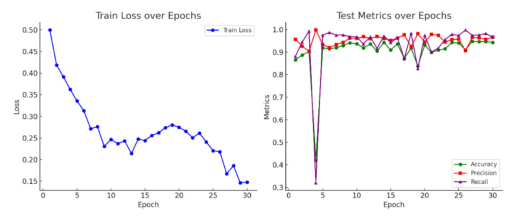

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = "Best_training.jpg"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

Теперь провалидируем на изначальных валидационных аудио, не нарезая их(однако для обучения во всех случаях мы нарезали на 10-15 сек)

Для этого немного изменим класс датасет и проинициализируем валидационный даталоадер заново:

In [14]:
class AphasiaDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_sample_rate=16000, fft_size=512, 
                 hop_length=256, win_length=512, min_duration=10, max_duration=15):
        self.root_dir = root_dir
        self.target_sample_rate = target_sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.min_duration = min_duration * 1000  # миллисекунды
        self.max_duration = max_duration * 1000
        self.data = []
        self.is_validation = "val_filenames.csv" in csv_file  # Проверяем, является ли датасет валидацией

        df = pd.read_csv(csv_file)

        for _, row in df.iterrows():
            file_name, label = row['file_name'], row['label']
            file_path = self.find_audio_file(file_name, label)
            if file_path:
                try:
                    segments = self.process_audio(file_path)
                    self.data.extend([(s, label) for s in segments])
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
        
        random.shuffle(self.data)
    
    def find_audio_file(self, file_name, label):
        folder = "Aphasia" if label == 1 else "Norm"
        file_name = file_name[:-4]
        file_path = os.path.join(self.root_dir, folder, f"{file_name}.3gp")
        if os.path.exists(file_path):
            return file_path
        print(f"Warning: {file_name}.3gp not found in {folder} folder.")
        return None

    def process_audio(self, file_path):
        audio = AudioSegment.from_file(file_path, format="3gp")
        if self.is_validation:
            return [self.create_spectrogram(audio)]  # Возвращаем аудио целиком
        
        duration = len(audio)
        segments = []

        if duration < self.min_duration:
            return [self.create_spectrogram(audio)]

        start = 0
        while start + self.min_duration <= duration:
            segment_duration = min(random.randint(self.min_duration, self.max_duration), duration - start)
            end = start + segment_duration
            segment = audio[start:end]
            spectrogram = self.create_spectrogram(segment)
            if spectrogram is not None:
                segments.append(spectrogram)
            start = end
        return segments

    def create_spectrogram(self, segment):
        try:
            buffer = BytesIO()
            segment.export(buffer, format="wav")
            buffer.seek(0)
            waveform, sample_rate = torchaudio.load(buffer)
            
            if sample_rate != self.target_sample_rate:
                resampler = Resample(sample_rate, self.target_sample_rate)
                waveform = resampler(waveform)
            
            if waveform.shape[1] < self.fft_size:
                return None
            
            y = waveform.numpy().squeeze()
            spectrogram = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
            mag = np.abs(spectrogram).astype(np.float32)
            return torch.tensor(mag.T).unsqueeze(0)  # (1, T, F)
        except Exception as e:
            print(f"Spectrogram error: {str(e)}")
            return None


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrogram, label = self.data[idx]
        return spectrogram, torch.tensor(label, dtype=torch.long)

def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)
    
    spectrograms, labels = zip(*batch)
    max_len = max(s.shape[1] for s in spectrograms)
    freq_bins = spectrograms[0].shape[2]
    
    padded = torch.zeros(len(spectrograms), 1, max_len, freq_bins)
    for i, s in enumerate(spectrograms):
        padded[i, :, :s.shape[1], :] = s
    
    return padded, torch.stack(labels) 


(Поскольку этот ноутбук оформляю локально, батчсайз тут меньше будет(ненарезанные аудио слишком большие), но на валидацию это никак не влияет)

In [15]:
root_dir = "aphasia"
val_dataset = AphasiaDataset("splited_data/val_filenames.csv", root_dir)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=pad_sequence, drop_last=True)
print(len(val_dataloader))

79


Аналогично иницализируем лучшую версию модели на данный момент и валидируем на изначальных аудио валидации:

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = CNNModel(num_classes=2).to(device)

state_dict = torch.load('aphasia_30.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
acc, prec, rec = evaluate_model(model, val_dataloader, criterion, device)
print(f"Validation Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

Validation: 100%|█████████████████████████████████████████████████████████████| 79/79 [04:52<00:00,  3.71s/it]

Validation Metrics - Accuracy: 0.9494, Precision: 0.9557, Recall: 0.9620


In [18]:
from sklearn.metrics import classification_report

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for spectrograms, labels in tqdm(val_dataloader, desc="Final Evaluation"):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        outputs = model(spectrograms)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        
report = classification_report(y_true, y_pred, target_names=["Norm", "Aphasia"])
print("\nFinal Classification Report:\n", report)


Final Evaluation: 100%|███████████████████████████████████████████████████████| 79/79 [06:00<00:00,  4.56s/it]


Final Classification Report:
               precision    recall  f1-score   support

        Norm       0.90      0.90      0.90        40
     Aphasia       0.97      0.97      0.97       118

    accuracy                           0.95       158
   macro avg       0.93      0.93      0.93       158
weighted avg       0.95      0.95      0.95       158



Метрики в случае нарезанного валидационного лоадера и исходного хорошие:)